# Better sampling *with* replacement?

In this article, we look at methods for estimating means in a finite population. [Previously](https://timvieira.github.io/blog/post/2017/07/03/estimating-means-in-a-finite-universe/), I wrote about the sampling *without* replacement methods for this problem.  Today, I am going to look at sampling *with* replacement.

Formally, we're going to compare a few methods for $K$-sparse representation of a probability distributions $p$ over $\{ 0, \ldots, n \}$.

Suppose, we sample points i.i.d. with replacement from a distribution $q$ over $\{ 0, \ldots, n \}$.

$$
x_1, \ldots, x_K \overset{\text{i.i.d.}}{\sim} q
$$

We then put the samples in a list

$$
S = [x_1, \ldots, x_K]
$$

**Goal:** A method for taking the sample $S$ and forming an unbiased $N$-dimensional representation of the distribution with at most $K$ nonzero elements.

$$
\widehat{p}(S) \quad\text{such that}\quad \text{for all } S, \|\widehat{p}(S) \|_0 \le K, \text{ and } \mathbb{E}_S\left[ \widehat{p}(S) \right] = p
$$

Clearly, we'd rather sample without replacement.  But, suppose for technical reasons, we are only allowed i.i.d. draws from a distributions $q$ that we are allowed to manipulate.  How far can we push this scheme?

**Estimators:** We will compare two estimators that operate on *exactly* the same sample $S$.  The primary difference between the two methods is that method 2 puts the samples in a set (removing duplicates) and method 1 keeps them in a list.

*Method 1: Importance sampling estimator*

$$
\widehat{p}_i(X) = \frac{1}{K} \sum_{k=1}^K \frac{p(x_k)}{q(x_k)} 1[ x_k = i ]\quad\text{for } i = 1,\ldots,n
$$

*Method 2: Horvitz–Thompson estimator*

$$
\widehat{p}_i(X) = \frac{p_i}{\pi_i} 1[ i \in S ]\quad\text{for } i = 1,\ldots,n
$$

where $\pi_i = \mathrm{Pr}\left[ i \in S \right]$

Notice that both estimators are positive, but neither estimator is guaranteed to sum to 1 for all choices of $q$.

What's the inclusion probability $\pi$? If we take $K$ i.i.d. samples with replacement from $q$, what is the probability that we sample item i at least once?
$$
\begin{align}
\pi_i 
&= \mathrm{Pr}[ i \in S ] \\
&= 1 - \mathrm{Pr}[ i \not\in \{ X_1, \ldots, X_k \} ] \\
&= 1 - \mathrm{Pr}[ X \ne i ]^k     \quad\text{# $X$'s are i.i.d} \\
&= 1 - (1 - q_i)^k
\end{align}
$$
    
Warning: This design might not sample $k$ distinct items.  Thus, the inclusion probabilties are a bit unusual as they generally sum to less than $k$.

- Exercise for the reader: Show that $\sum_{i=1}^n 1 - (1 - q_i)^k \le k$ given $\sum_{i=0}^{n} q_i = 1$ and $q_1\ldots,q_n \ge 0$.

How do we know if we're doing a good job?  A reasonable metric is the expected sum of squared error

$$
\mathcal{E} = \mathbb{E}_S\left[ \sum_{i=1}^N \left( \widehat{p}_i(S) - p_i \right)^2 \right] 
$$

For IS,
$$
\mathcal{E}_{\mathrm{is}} = \frac{1}{k} \sum_{i=1}^n q_i \left( \frac{p_i}{q_i} - p_i \right)^2 + (1-q_i) p_i^2 = \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i} - p_i^2
$$

For HT,

$$
\mathcal{E}_{\mathrm{ht}}
= \sum_{i=1}^n \pi_i \left( \frac{p_i}{\pi_i} - p_i \right)^2 + (1-\pi_i) p_i^2 
= \sum_{i=1}^n  \frac{p_i^2}{\pi_i} - p_i^2
= \sum_{i=1}^n  \frac{p_i^2}{1 - (1 - q_i)^k} - p_i^2
$$

**How to pick $q$?** The choice of $q$ is important.  The optimal choice for importance sampling is $q=p$; regardless of $K$.  However, the optimial choice for HTMC is different. I do not believe there is a closed form solution for it (it seems unlikely given that it is the root of a high-degree polynomial in $k$), but it can be found numerically and it depends on $K$.

## Experiments

In [1]:
def importance_sampling(p, q, u):
    n = len(p); k = len(u)
    Y = sample(q, u=u)
    x = np.zeros(n)
    for i in Y: x[i] += p[i]/q[i]
    return x / k

Next, we will consider applying the Horvitz–Thompson estimator for sampling *with* replacement from a finite population.  Below, is an implementation of the estimator.

In [2]:
def ht(p, pi, S):
    x = np.zeros(n)
    for i in S: x[i] += p[i]/pi[i]  # HT estimator
    return x

def htmc(p, q, u):
    n = len(p); k = len(u)
    Y = sample(q, u=u)      # sample with replacement from q
    S = set(Y)              # removes duplicates [ |Y| <= k ]
    pi = (1 - (1 - q)**k)   # inclusion probabilities
    return ht(p, pi, S)    

Set up a synthetic estimation problem.  The distribution $p$ is sampled form a distribution which is very likely to have a few heavy hitters.

In [3]:
import numpy as np, pylab as pl
from arsenal import iterview
from arsenal.maths import random_dist, sample, spherical, anneal, fdcheck, random_dist, softmax, d_softmax
from collections import defaultdict
from scipy.optimize import minimize

n = 20
p = anneal(random_dist(n), invT=2)

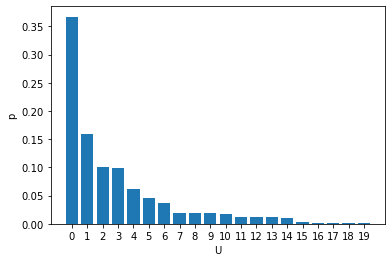

In [4]:
pl.bar(range(n), np.sort(p)[::-1]); pl.ylabel('p'); pl.xlabel('U'); pl.xticks(range(n));

In [5]:
def var_importance_sampling(p, q, k):
    n = len(p)
    x = np.zeros(n)
    for i in range(n):        
        x[i] += p[i]**2/q[i] - p[i]**2               
    return np.sum(x / k)

def var_ht(p, pi, k):
    return sum(
        p[i]**2/pi[i] - p[i]**2
        for i in range(n)
    )

def var_htmc(p, q, k):
    assert len(p) == len(q) == n, [len(p), len(q), n]
    assert np.allclose(np.sum(q), 1.0)
    incl = 1 - (1 - q)**k    
    return var_ht(p, incl, k)

def d_var_htmc(p, q, k):
    incl = (1-(1-q)**k)
    return p**2 * -incl**-2 * (1-q)**(k-1) * k

def d_var_htmc_softmax(p, w, k):
    q = softmax(w)
    return d_softmax(q, w, d_var_htmc(p, q, k))

In [6]:
T = 2*n
reps = 1000
ts = range(1,1+T)

def ht_optimized(p, u): 
    return htmc(p, htmc_opt_p(len(u)), u)

from arsenal.cache import memoize
@memoize
def htmc_opt_p(k):
    sol = minimize(lambda w: var_htmc(p, softmax(w), k), np.log(p), 
                   jac=lambda w: d_var_htmc_softmax(p, w, k))
    return softmax(sol.x)

In [7]:
methods = {
    'mc': (
        lambda u: importance_sampling(p, p, u), 
        lambda k: var_importance_sampling(p, p, k),
    ),
    'ht-direct': ( 
        lambda u: htmc(p, p, u),
        lambda k: var_htmc(p, p, k),
    ),
    'ht-opt': (
        lambda u: ht_optimized(p, u), 
        lambda k: var_htmc(p, htmc_opt_p(k), k),
    ),
}

In [8]:
runs = defaultdict(list)
u = np.random.uniform(0,1,size=(reps, T))    # common random numbers
for r in iterview(range(reps)):
    for name in methods:
        method, _ = methods[name]
        runs[name].append([method(u[r,:t]) for t in range(1,T+1)])

100.0% (1000/1000) [==================================================] 00:00:05


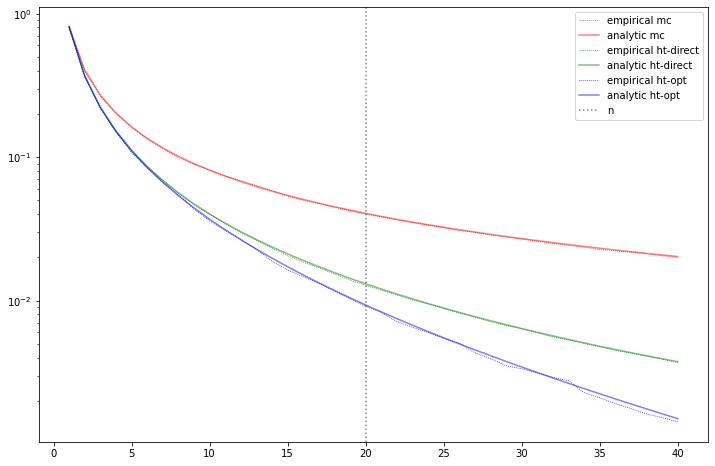

In [9]:
from arsenal.viz import name2color
pl.figure(figsize=(12,8))
C = name2color()
for name in runs:
    err = (np.abs(runs[name] - p[None,None,:])**2).sum(axis=2)
    m = np.mean(err, axis=0)
    pl.plot(ts, m, c=C[name], linestyle=':', lw=.75, label=f'empirical {name}')
    _, analytic = methods[name]
    if analytic is not None: 
        pl.plot(ts, [analytic(t) for t in ts], label=f'analytic {name}', 
                c=C[name], alpha=0.5)
pl.axvline(n, label='n', c='k', linestyle=':', alpha=0.5)
pl.legend(loc='best'); #pl.loglog(); 
pl.semilogy();

# Variance analysis

#### Optimal proposal distribution ($q=p$)

I have previously [ranted](https://timvieira.github.io/blog/post/2016/05/28/the-optimal-proposal-distribution-is-not-p/) about how the optimal proposal distribution is not $q$.  However, under the unbiased + expected squared error conditions.  It is the optimal choice for the importance sampling type estimators.  We formalized this below.

**Proposition:** The minimum variance choice for $q$ is $p$.

## Gradient of HT-MC variance

In [10]:
k = 20
q = random_dist(n)
fdcheck(lambda: var_htmc(p, q, k), q, d_var_htmc(p, q, k), throw=False);


Comparison: n=20
  norms: [53.5875, 53.5875]
  pearson: 1
  spearman: 1
  ℓ∞: 4.27397e-05
  ℓ₂: 4.27611e-05
  same-sign: 100.0% (20/20)
  regression: [1.000 0.000] R=0.000
  have is larger:  95.0% (19/20)



100.0% (20/20) [======================================================] 00:00:00


In [11]:
w = spherical(n)
k = 5
fdcheck(lambda: var_htmc(p, softmax(w), k), w, d_var_htmc_softmax(p, w, k), throw=False);


Comparison: n=20
  norms: [0.53744, 0.53744]
  pearson: 1
  spearman: 1
  ℓ∞: 4.78044e-11
  ℓ₂: 1.13039e-10
  same-sign: 100.0% (20/20)
  regression: [1.000 -0.000] R=0.000



100.0% (20/20) [======================================================] 00:00:00


# Proofs

**Proposition:** The optimial importance sampling proposal is $q=p$

**Proof:** First, we write out the Lagrangian for picking $q$ with optimal variance:
$$
\begin{cases}
\underset{{q_1, \ldots q_n}}{\mathrm{minimize}}\
   & \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i} \\
\mathrm{subject\ to} 
  & \sum_{i=1}^n q_i = 1 \\
  & q_1, \ldots q_n \ge 0
\end{cases}
$$

$$
L(q_1, \ldots q_n, \lambda) 
= \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i}
- \lambda \left(1 - \sum_{i=1}^n q_i \right)
$$

Now, solve for $q$ and $\lambda$ which make $L$'s parital derivatives similatenously zero.
$$
\begin{align}
0
&= \nabla_{q_j}\left[  L(q_1, \ldots q_n, \lambda) \right] \\
&= \nabla_{q_j}\left[ \frac{1}{k} \sum_{i=1}^n \frac{p_i^2}{q_i}  - \lambda \left( 1 - \sum_{i=1}^n q_i \right) \right] \\ 
&= \frac{1}{k} \sum_{i=1}^n 
    \nabla_{q_j}\left[ \frac{p_i^2}{q_i} \right]  
     + \lambda \sum_{i=1}^n \nabla_{q_j}\left[ q_i \right] \\
&= \lambda - \frac{1}{k} \frac{p_j^2}{q_j^2} \\
\lambda &= \frac{1}{k} \frac{p_j^2}{q_j^2} \\
q_j^2 &= \frac{p_j^2 }{ k \lambda } \\
\sqrt{q_j^2} &= \sqrt{\frac{p_j^2 }{ k \lambda }} \\
q_j &= \frac{p_j}{ \sqrt{ k \lambda }} \\
\end{align}
$$

and, the constraint that $\nabla_\lambda L = 0$ just replicates the constraint corresponding to $\lambda$.
$$
\begin{align}
\left(1 - \sum_{i=1}^n q_i \right) &= 0 \\
1 &= \sum_{i=1}^n q_i
\end{align}
$$

Clearly, the only valid solution to all these equations is $q = p$.  Furthermore, this choice is optimal for any valid choice $k$.

In [12]:
# Empirical verification
sol = minimize(lambda w: var_importance_sampling(p, softmax(w), k=20), np.zeros(n))
compare(softmax(sol.x), p);


Comparison: n=20
  norms: [0.435396, 0.4354]
  pearson: 1
  spearman: 1
  ℓ∞: 0.000101288
  ℓ₂: 0.000207245
  same-sign: 100.0% (20/20)
  regression: [1.000 0.000] R=0.000

